[Dataset](https://archive.ics.uci.edu/dataset/320/student+performance) by Paulo Cortez

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.inspection import DecisionBoundaryDisplay

from imblearn.over_sampling import SMOTE

%matplotlib inline

# Data Preprocessing

Import libraries

In [ ]:
sns.set_theme()

Load data

In [ ]:
#df_maths = pd.read_csv('https://raw.githubusercontent.com/Theosdoor/KNN-vs-Logistic-Regression/refs/heads/main/data/student-mat.csv?token=GHSAT0AAAAAAC5AZKHNODB4SXM3NG63VYGCZ5POL3Q', sep = ';')
df_por = pd.read_csv('https://raw.githubusercontent.com/Theosdoor/KNN-vs-Logistic-Regression/refs/heads/main/data/student-por.csv?token=GHSAT0AAAAAAC5AZKHM2EGG4NLMNWXPDKDIZ5POMNA', sep = ';')

df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Preprocessing

In [ ]:
df_por = df_por.rename(columns={'G3': 'target'})

df_por['target'].value_counts(dropna=False)

11    104
10     97
13     82
12     72
14     63
15     49
16     36
9      35
8      35
17     29
18     15
0      15
7      10
6       3
19      2
1       1
5       1
Name: target, dtype: int64

In [ ]:
# For binary classification, consider pass/fail. Pass if target >= 10, else fail
df_por['target'] = df_por['target'].apply(lambda x: 'pass' if x >= 10 else 'fail')

df_por['target'].value_counts()
# imbalanced - lots more passes than fails

pass    549
fail    100
Name: target, dtype: int64

In [ ]:
df_por['target'].value_counts()

pass    549
fail    100
Name: target, dtype: int64

(0.0, 100.0)

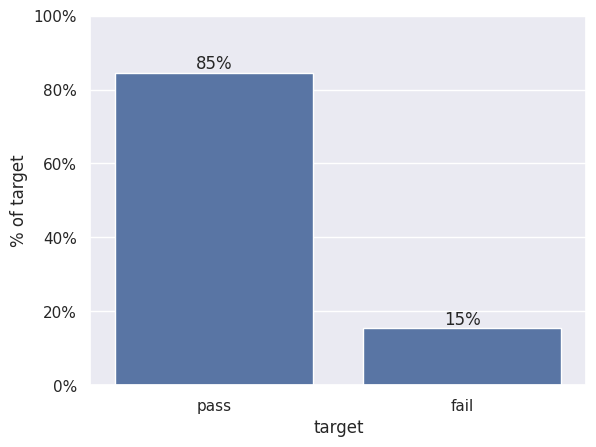

In [ ]:
import matplotlib.ticker as mtick

fig_df = pd.DataFrame(df_por['target'].value_counts()).reset_index()
fig_df.rename({'target' : '% of target', 'index' : 'target'}, axis = 1, inplace = True)
fig_df['% of target'] = fig_df['% of target'].apply(lambda x: x / fig_df['% of target'].sum() * 100)


fig = sns.barplot(fig_df, x = 'target', y = '% of target')

# add % to top of bars
for con in fig.containers:
    fig.bar_label(con, fmt = '%.f%%')

fig.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylim(0, 100)

# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/target-imbalance-bar.png", bbox_inches = 'tight')

In [ ]:
# dataset visualisation + linear seperability
check = ['absences', 'G1', 'G2', 'target']

# sns.pairplot(df_por[check], hue = 'target')
# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/pair-plot.png", bbox_inches = 'tight')

In [ ]:
df_por.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [ ]:
# see unique values in each feature and how many times each appears

# for col in df_por.columns.tolist():
#   print(df_por[col].value_counts(dropna=False), '\n')

Explore dataset

In [ ]:
# transform target so pass is 1, fail is 0
df_por['target'] = df_por['target'].replace({'pass' : 1, 'fail' : 0})
df_por['target'].value_counts()

1    549
0    100
Name: target, dtype: int64

In [ ]:
# fig_data = df_por[['G1', 'G2', 'target']]

# fig = sns.heatmap(fig_data.corr(numeric_only = True), annot = True, fmt = ".2f")
# fig.set_yticklabels(fig.get_yticklabels(), rotation = 0)

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'Medu'),
 Text(2.5, 0, 'Fedu'),
 Text(3.5, 0, 'traveltime'),
 Text(4.5, 0, 'studytime'),
 Text(5.5, 0, 'failures'),
 Text(6.5, 0, 'famrel'),
 Text(7.5, 0, 'freetime'),
 Text(8.5, 0, 'goout'),
 Text(9.5, 0, 'Dalc'),
 Text(10.5, 0, 'Walc'),
 Text(11.5, 0, 'health'),
 Text(12.5, 0, 'absences'),
 Text(13.5, 0, 'G1'),
 Text(14.5, 0, 'G2'),
 Text(15.5, 0, 'target')]

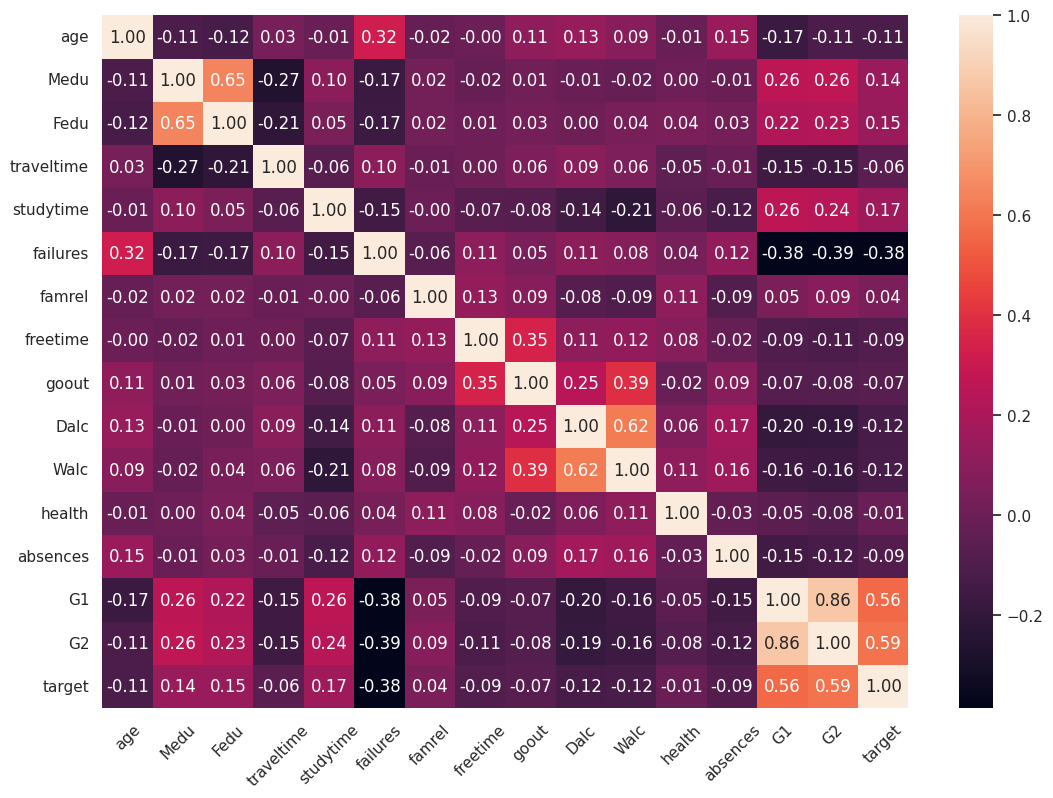

In [ ]:
fig, ax = plt.subplots(figsize = (13, 9))

ax = sns.heatmap(df_por.corr(numeric_only = True), annot = True, fmt = ".2f")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/dataset-heatmap.png", bbox_inches = 'tight')

**Setup for preprocessing**

In [ ]:
# SPLIT INTO FEATURE AND TARGET ARRAYS
X = df_por.drop('target', axis = 1)
y = df_por['target']

**Reweighting** since data imbalanced
- [Alternative reweighting strategy](https://link.springer.com/content/pdf/10.1007/978-0-387-74161-1_4.pdf)
- [Using sklearn for reweighting](https://python.plainenglish.io/cost-sensitive-learning-using-logistic-regression-b3f3ba84e02b)


In [ ]:
# use class_weights = 'balanced' parameter in training to use these weights

# from sklearn.utils.class_weight import compute_class_weight
# weighting = compute_class_weight('balanced', classes = [0,1], y = y)
# weighting

# we have 0 : 3.2, 1 : 0.6

**Encode categorical features**





In [ ]:
# BINARY FEATURES - use label binarizer
lb = LabelBinarizer()
binary_cols = ['sex', 'school', 'address', 'Pstatus', 'famsize', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
# does sex, school and address work well like this?

for col in binary_cols:
  X[col] = lb.fit_transform(X[col])

In [ ]:
# check balance - mean should be close to 0.5 for balanced data

# for c in binary_cols:
  # print(X[c].describe())
  # print()

In [ ]:
# ONE-HOT ENCODING vs LABEL ENCODING vs DROPPING

# JUSTIFY --> does it make eg. MSE better? Must also show that we can avoid multicollinearity
nominal_data = ['Mjob', 'Fjob', 'guardian', 'reason']

# DROP NOMINAL DATA
# X = X.drop(nominal_data, axis = 1)

# ONE-HOT
print(X.shape)
X = pd.get_dummies(X, columns = nominal_data, drop_first = True) # drop first to avoid "dummy trap" of multicollinearity (VIF massive!)
print(X.shape)

# LABEL ENCODING
# le = LabelEncoder()
# for f in nominal_data:
#   X[f] = le.fit_transform(X[f])

(649, 32)
(649, 41)


In [ ]:
# SEPERATE NUMERIC AND CATEGORICAL FEATURES
numeric_cols = ['age', 'Medu', 'Fedu', 'famrel', 'traveltime', 'studytime', 'failures', 'freetime', 'goout', 'Walc', 'Dalc', 'health', 'absences', 'G1', 'G2']
cat_cols = list(set(X.columns) - set(numeric_cols) - {'target'}) # get list of all cols in df excluding numeric cols and target col
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

['age', 'Medu', 'Fedu', 'famrel', 'traveltime', 'studytime', 'failures', 'freetime', 'goout', 'Walc', 'Dalc', 'health', 'absences', 'G1', 'G2']
['Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Pstatus', 'activities', 'address', 'famsize', 'famsup', 'guardian_mother', 'guardian_other', 'higher', 'internet', 'nursery', 'paid', 'reason_home', 'reason_other', 'reason_reputation', 'romantic', 'school', 'schoolsup', 'sex']


In [ ]:
# SPLIT INTO WITH AND WITHOUT PREVIOUS GRADES HERE
# create 2 datasets: one with and one without G1, G2 so we can compare predictions and importance of these two variables
X_nogrades = X.drop(['G1', 'G2'], axis = 1)

# if testing without G1, G2, uncomment these lines:
# ==================================================
# X = X_nogrades
# numeric_cols = numeric_cols[:-2] # remove G1, G2

**Scaling and normalisation of numerical features**

In [ ]:
# STANDARDIZE NUMERICAL FEATURES
scaler = StandardScaler()

for c in numeric_cols:
  arr = np.array(X[c]).reshape(-1,1)
  scaler.fit(arr)
  X[c] = scaler.transform(arr) # returns ndarray of scaled num_col values

print(X.shape)

(649, 41)


In [ ]:
# pd.concat([np.mean(X), np.std(X)], axis = 1)
# 1st column is mean, 2nd col is standard deviation for each feature

**Further exploration**

In [ ]:
# check linear seperability (i.e. whether logistic regression is suitable)
# https://maurygreen.medium.com/how-to-check-for-linear-separability-13c177ae5a6e

# from sklearn.svm import SVC
# test = SVC(kernel = 'linear', C = 2**15) # accuract = 0.95686

# # test = LogisticRegression(C = np.inf, max_iter = 2**32)

# test.fit(X, y)
# print('Accuracy = {:.5f}'.format(accuracy_score(y, test.predict(X))))

In [ ]:
# Check Variance Inflation Factor (VIF) of each feature to check multicollinearity (could be caused by one-hot!)
# Important to check because greatly affects logistic regression models
# Square root of VIF shows how different that feature is than if it was not correlated at all.

# from https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
def get_vifs(df):
  return pd.Series(np.linalg.inv(df.corr().to_numpy()).diagonal(), index=df.columns, name='VIF')

vifs = get_vifs(X)
# g1, g2, Medu, Fjob_other and Fjob_services have largest VIFs

# vifs = vifs[vifs.lt(2.5)] # get features less with VIF < 2.5
# X = X[vifs.index.tolist()] # remove from X
vifs

school               1.543190
sex                  1.396165
age                  1.441222
address              1.325787
famsize              1.147306
Pstatus              1.188280
Medu                 2.693316
Fedu                 2.097869
traveltime           1.295665
studytime            1.252686
failures             1.433040
schoolsup            1.170565
famsup               1.129967
paid                 1.102953
activities           1.141829
nursery              1.066142
higher               1.318247
internet             1.246631
romantic             1.126229
famrel               1.135742
freetime             1.273425
goout                1.459178
Dalc                 1.834196
Walc                 2.113194
health               1.146914
absences             1.231988
G1                   4.430493
G2                   4.307080
Mjob_health          1.813305
Mjob_other           2.011722
Mjob_services        2.113154
Mjob_teacher         2.277617
Fjob_health          1.767930
Fjob_other

**Test/train split**

In [ ]:
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed, stratify = y)
# stratify so each set gets equal proportion of G3 passes/fails (pass = 1, fail = 0)

print(X_train.shape)
print(X_test.shape)
print()
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

(519, 41)
(130, 41)

1    0.845857
0    0.154143
Name: target, dtype: float64
1    0.846154
0    0.153846
Name: target, dtype: float64


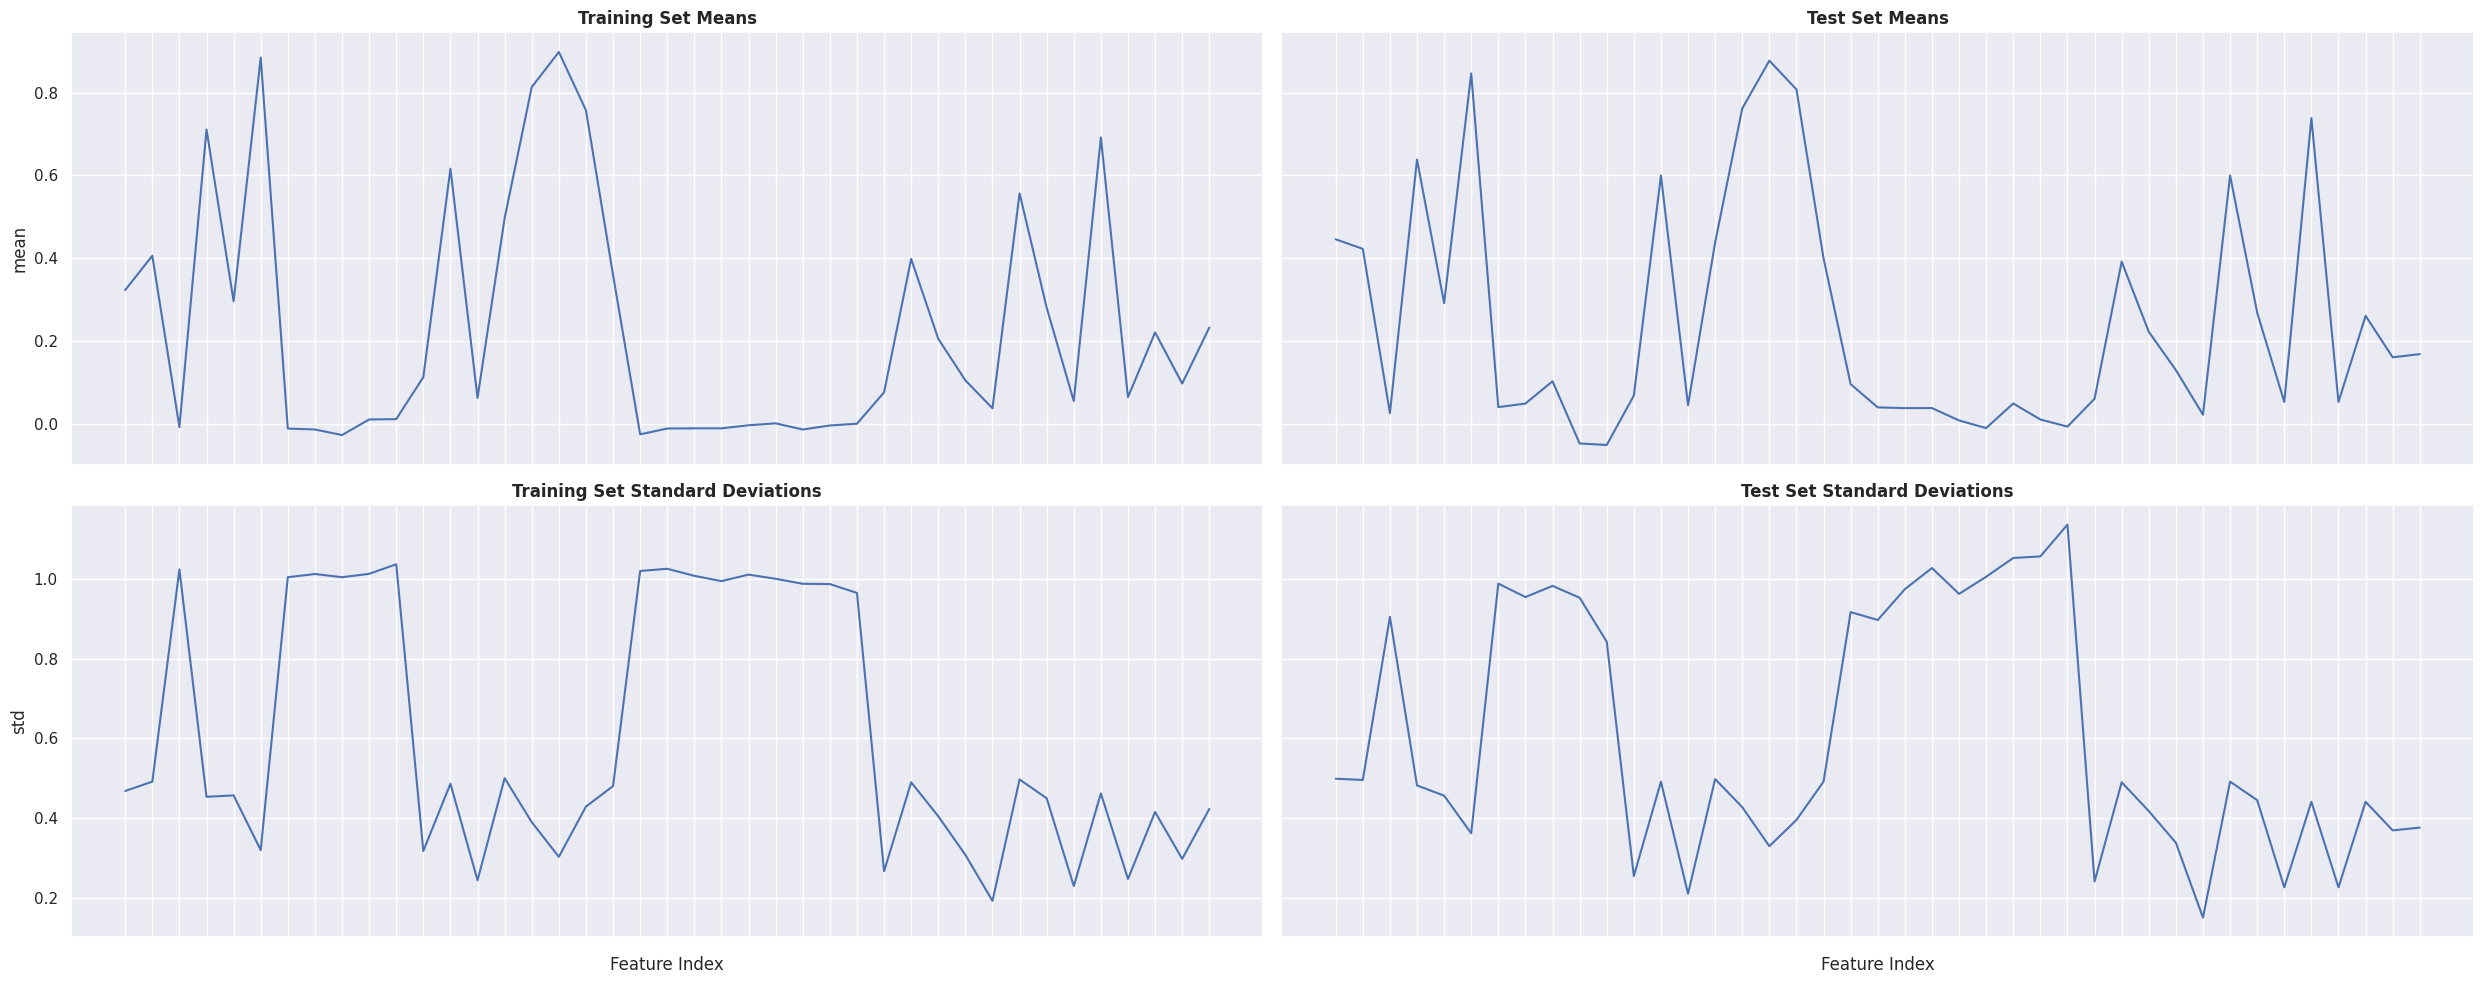

In [ ]:
train_fig_data = X_train.describe().drop(['count']).T
test_fig_data = X_test.describe().drop(['count']).T

train_fig_data.reset_index(inplace=True)
test_fig_data.reset_index(inplace=True)

# want each row to look similar

fig, axs = plt.subplots(2, 2, sharex = True, sharey = 'row', figsize = (25, 10))

sns.lineplot(train_fig_data, x = 'index', y = 'mean', ax = axs[0][0])
sns.lineplot(test_fig_data, x = 'index', y = 'mean', ax = axs[0][1])
sns.lineplot(train_fig_data, x = 'index', y = 'std', ax = axs[1][0])
sns.lineplot(test_fig_data, x = 'index', y = 'std', ax = axs[1][1])

for ax in axs[1]: # each row
  ax.set_xticklabels('')
  ax.set_xlabel('Feature Index')

axs[0][0].set_title('Training Set Means', fontweight = 'bold')
axs[0][1].set_title('Test Set Means', fontweight = 'bold')
axs[1][0].set_title('Training Set Standard Deviations', fontweight = 'bold')
axs[1][1].set_title('Test Set Standard Deviations', fontweight = 'bold')

plt.tight_layout()
# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/train-vs-test-set-mean-std.png", bbox_inches = 'tight')

In [ ]:
# data balancing using SMOTE
# print(y_train.value_counts())

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X, y)

# y_train.value_counts()

## PCA & dimensionality reduction

Some code seen in this section was taken or adapted from these sources:
- [Visualising eigenvalues](https://medium.com/data-science-365/2-plots-that-help-me-to-choose-the-right-number-of-principal-components-351a87e15a9f#:~:text=We%20usually%20prefer%20to%20keep,much%20variance%20in%20the%20data) (article)
- [Applying PCA to data](https://github.com/lshi/ml/blob/main/pca.ipynb)
(github)


In [ ]:
# check eigenvalues to decide how many principal components we need to keep variance mostly intact
pca = PCA(n_components = None)
pca.fit(X_train) # need to do with training set only so as not to leak test data!

eigen_vals = pca.explained_variance_
eigen_vals

array([3.1662045 , 2.06209516, 1.38185112, 1.27861152, 1.17690403,
       1.01529802, 0.93742514, 0.88696194, 0.84077054, 0.80769893,
       0.68743407, 0.60221198, 0.41568719, 0.37426769, 0.35639161,
       0.27463667, 0.24713139, 0.2318578 , 0.22660957, 0.2232613 ,
       0.21746903, 0.18832432, 0.17665186, 0.15632013, 0.14408816,
       0.13827757, 0.13448759, 0.12750836, 0.11625218, 0.11089461,
       0.0902111 , 0.08492174, 0.07854009, 0.07360513, 0.06085552,
       0.05657774, 0.05245368, 0.03956117, 0.03444003, 0.02187812,
       0.01134472])

In [ ]:
sns.set_style("darkgrid") # add grid lines to graphs

In [ ]:
# Scree plot to visualise eigenvalues
# steep = lots of variance, shallow = not much variance

# plt.plot(eigen_vals, marker='o', color='blue')
# plt.xlabel("Eigenvalue number")
# plt.ylabel("Eigenvalue size")
# plt.title("Scree Plot")

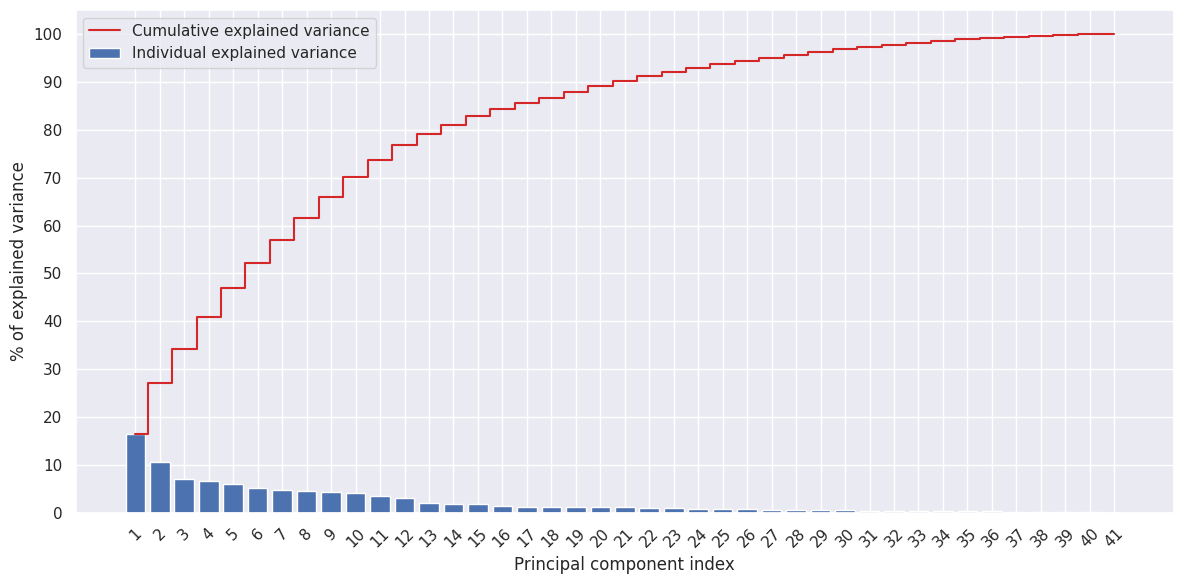

In [ ]:
# cumulative explained variance plot
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

a = X_train.shape[-1] + 1 # Number of input features + 1

plt.figure(figsize=(12,6))

plt.bar(range(1, a), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, a), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='#d62728', lw = '1.5')

plt.ylabel('% of explained variance')
plt.xlabel('Principal component index')
plt.yticks(ticks = list(range(0,105,10)))
plt.xticks(ticks=list(range(1, a)), rotation = 45)
plt.legend(loc='best')
plt.tight_layout()

# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/cumulative-explained-variance-plot.png", bbox_inches = 'tight')

If we include G1 & G2, we see that 85% of the variance is captured by 16 out of the 41 features! More than 80% by just 13, and 90% by just under half (20) of them! (using one-hot encoding)

In [ ]:
keep = 16 # keep first 16 principal components for 85% variance
pca = PCA(n_components = keep)

# comment these lines to remove dimension reduction
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

print(X_train.shape)
print(X_test.shape)

(519, 16)
(130, 16)


In [ ]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.16390225 0.10700252 0.09231769 0.07865006 0.06533128 0.05793736
 0.04901358 0.04034495 0.03753555 0.0314894  0.02910933 0.025186
 0.02279761 0.01794301 0.01722841 0.01516479]


# Modelling

## Setup

In [ ]:
# CROSS VALIDATION
# Use statified k-fold cross validation for model selection
# ref paper does 20 repeats of 10 fold
random_seed = 42
n_splits = 10
n_repeats = 20
scoring = ['f1', 'recall', 'roc_auc']

# create x-validators
rskf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = random_seed)

In [ ]:
# HYPERPARAMETER TUNING using exhaustive grid search
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_auc, std_auc, mean_f1, std_f1, params in zip(
        filtered_cv_results["mean_test_roc_auc"],
        filtered_cv_results["std_test_roc_auc"],
        filtered_cv_results["mean_test_f1"],
        filtered_cv_results["std_test_f1"],
        filtered_cv_results["params"],
    ):
        print(
            f"auc: {mean_auc:0.3f} (±{std_auc:0.03f}),"
            f" f1: {mean_f1:0.3f} (±{std_f1:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a threshold for AUC,
    rank the remaining by f1 score and keep all models with one standard
    deviation of the best by f1 score. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    auc_threshold = 0.8

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)


    # Filter-out all results below the threshold
    high_auc_cv_results = cv_results_[
        cv_results_["mean_test_roc_auc"] > auc_threshold
    ]

    print(f"Models with an auc higher than {auc_threshold}:")
    print_dataframe(high_auc_cv_results)

    high_auc_cv_results = high_auc_cv_results[
        [
            "mean_score_time",
            "mean_test_f1",
            "std_test_f1",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_roc_auc",
            "std_test_roc_auc",
            "rank_test_f1",
            "rank_test_recall",
            "rank_test_roc_auc",
            "params",
        ]
    ]

    # Select the most performant models in terms of f1
    # (within 1 sigma from the best)
    best_f1_std = high_auc_cv_results["mean_test_f1"].std()
    best_f1 = high_auc_cv_results["mean_test_f1"].max()
    best_f1_threshold = best_f1 - best_f1_std

    high_f1_cv_results = high_auc_cv_results[
        high_auc_cv_results["mean_test_f1"] > best_f1_threshold
    ]
    print(
        "Out of the previously selected high auc models, we keep all the\n"
        "the models within one standard deviation of the highest f1-scoring model:"
    )
    print_dataframe(high_f1_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_f1_high_auc_index = high_f1_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on auc and f1 score.\n"
        "Its scoring time is:\n\n"
        f"{high_f1_cv_results.loc[fastest_top_f1_high_auc_index]}"
    )

    return fastest_top_f1_high_auc_index

## Logistic regression


Train model

In [ ]:
random_seed = 42
# https://scikit-learn.org/stable/modules/linear_model.html
tuned_parameters = {
    # 'penalty' : [None, 'l2'], # tune regularisation / penalty function. l1 = lasso, l2 = ridge
    'C' : [0.01, 0.1, 1, 10, 100, 1000],
    # 'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky'], # regardless of solver we choose, barely any difference
    }

# lr = GridSearchCV(LogisticRegression(penalty = 'l2', class_weight = 'balanced', max_iter=1000, random_state = random_seed), tuned_parameters, scoring = scoring, refit = refit_strategy, cv = rskf)
lr = LogisticRegression(penalty = 'l2', class_weight = 'balanced', C = 0.1, max_iter = 1000, random_state = random_seed)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42)

Evaluate model

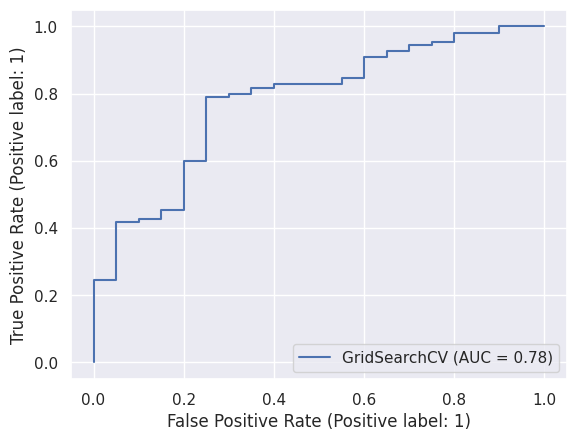

In [ ]:
RocCurveDisplay.from_estimator(lr, X_test, y_test) # receiver operator characteristic
# good classifier if close to top left corner
# worst if close to line y = x (random guess)

# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/lr-roc-auc.png", bbox_inches = 'tight')

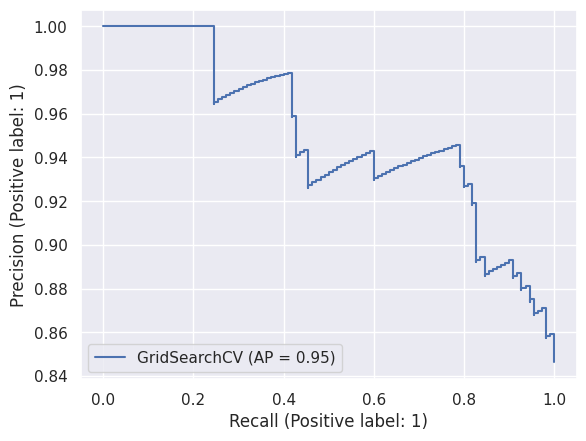

In [ ]:
PrecisionRecallDisplay.from_estimator(lr, X_test, y_test)

# precision = proportion of positive predictions, that are actually positive (TP / (TP + FP))
# recall = proportion of positives that were correctly identified (TP / (TP + FN))
# best in top right corner

# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/lr-prec-recall.png", bbox_inches = 'tight')

In [ ]:
lr.best_estimator_.coef_
# parameters

array([[-1.56929498,  0.21206901, -0.34038155, -0.57456514,  0.94850686,
        -0.34865654,  0.48644974,  0.34335688, -0.14127046,  0.5734884 ,
         0.23010395,  0.09613831, -0.00937754,  0.03461681,  0.08593803,
         0.06083586]])

## KNN

Select and train model

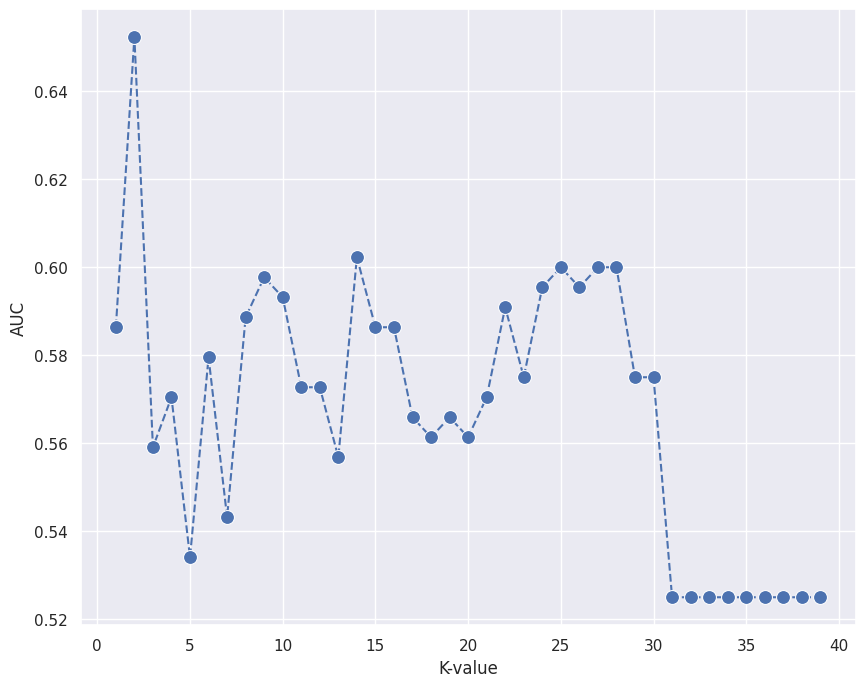

In [ ]:
# ERROR FOR DIFFERENT VALUES OF K
# code adapted from https://github.com/lshi/ml/blob/main/knn.ipynb
err = []

# Calculating error for K values between 1 and 40
n_k_values = 40
for i in range(1, n_k_values):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train, y_train)
    pred_i = clf.predict(X_test)
    # err.append(np.mean(pred_i != y_test))
    err.append(roc_auc_score(y_test, pred_i))

err_ser = pd.Series(err)
err_ser.index += 1 # put into Series to adjust indexes to plot

sns.set_style('darkgrid')
plt.figure(figsize=(10, 8))

sns.lineplot(err_ser, linestyle = 'dashed', marker = 'o', markersize = 10)

# plt.title('Mean Error vs K-value')
# plt.title('AUC vs K-value')
plt.xlabel('K-value')
# plt.ylabel('Mean Error')
plt.ylabel('AUC')

# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/mean-error-vs-k-value-lineplot.png", bbox_inches = 'tight')
plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/auc-vs-k-value-lineplot.png", bbox_inches = 'tight')

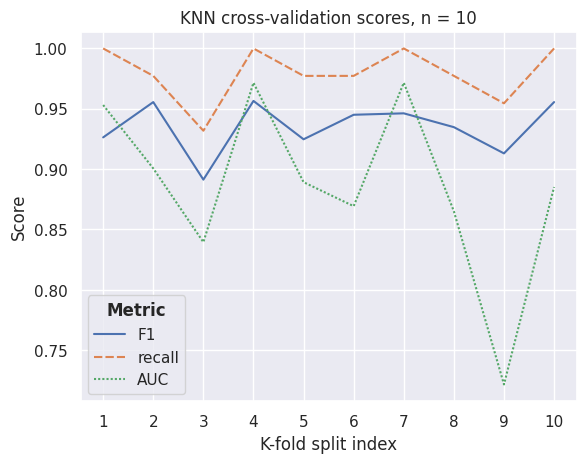

In [ ]:
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_seed)

# get scores from x-validation
scores = cross_validate(KNeighborsClassifier(n_neighbors = 10), X_train, y_train, scoring = scoring, cv = skf)

# convert to dataframe
scores_df = pd.DataFrame(scores)
scores_df.index += 1 # start indexing from 1 (1st k-fold split)
scores_df.rename({'test_f1' : 'F1', 'test_recall' : 'recall', 'test_roc_auc' : 'AUC'}, axis = 1, inplace = True)

# plot performance of each k-fold split
sns.lineplot(scores_df[['F1', 'recall', 'AUC']])

plt.ylabel('Score')
plt.xlabel('K-fold split index')
plt.title('KNN cross-validation scores, n = 10')
plt.xticks(list(range(1, n_splits+1)))
plt.legend(title = 'Metric', title_fontproperties = {'weight' : 'bold'})

In [ ]:
# tune hyperparameter k, testing k between 1 and 30,
# as well as p (from minkowski distance formula) for euclidean (p = 2) or manhattan (p = 1) dist
min_k = 5
max_k = 20
tuned_parameters = {'n_neighbors': list(range(min_k, max_k + 1)),
                    'p' : [1,2]
                    }

# knn = GridSearchCV(KNeighborsClassifier(), tuned_parameters, scoring = scoring, refit = refit_strategy, cv = rskf)
knn = KNeighborsClassifier(n_neighbors = 10, p = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

Evaluate model

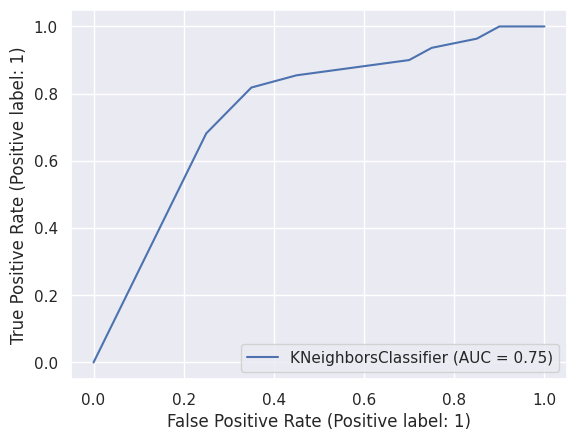

In [ ]:
RocCurveDisplay.from_estimator(knn, X_test, y_test) # receiver operator characteristic
# good classifier if close to top left corner
# worst if close to line y = x (random guess)
# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/knn-roc-auc.png", bbox_inches = 'tight')

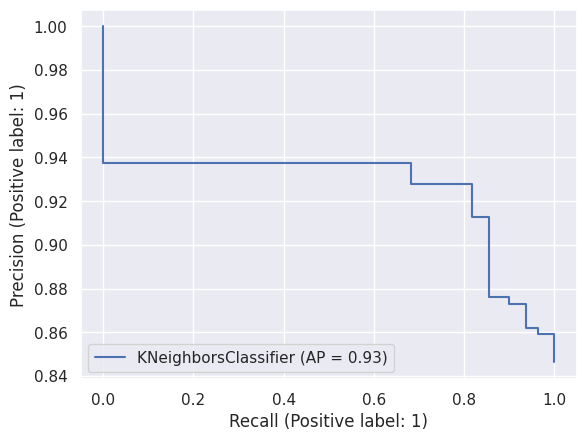

In [ ]:
PrecisionRecallDisplay.from_estimator(knn, X_test, y_test)

# precision = proportion of positive predictions, that are actually positive (TP / (TP + FP))
# recall = proportion of positives that were correctly identified (TP / (TP + FN))
# best in top right corner

# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/knn-prec-recall.png", bbox_inches = 'tight')

## Evaluate & compare models

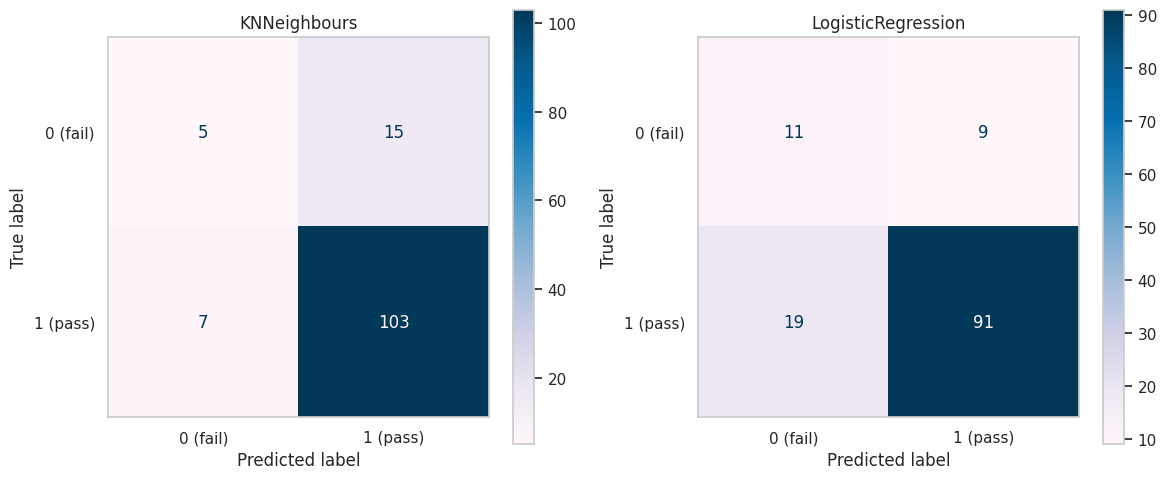

In [ ]:
clfs = [knn, lr]
sns.set_style("whitegrid", {'axes.grid' : False}) # remove grid from graphs

# from https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

for cls, ax in zip(clfs, axs.flatten()):
    ConfusionMatrixDisplay.from_estimator(cls, X_test, y_test, ax=ax, cmap='PuBu', display_labels = ['0 (fail)', '1 (pass)'])

axs[0].title.set_text("KNNeighbours")
axs[1].title.set_text("LogisticRegression")
plt.tight_layout()

# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/confusion-matrices.png", bbox_inches = 'tight')

In [ ]:
# code from https://github.com/lshi/ml/blob/main/Logistic_Regression.ipynb

prob = knn.predict_proba(X_test)[:, 1]
pred = knn.predict(X_test)

print('KNN:\n')
print('Log loss = {:.5f}'.format(log_loss(y_test, prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, prob))) # best = 1, worst = 0.5
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, prob)))

print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, pred))) # best = 1 worst = 0?

print('\nClassification Report')
print(classification_report(y_test, pred))

KNN:

Log loss = 1.61256
AUC = 0.75318
Average Precision = 0.92523

Using 0.5 as threshold:
Accuracy = 0.83077
Precision = 0.87288
Recall = 0.93636
F1 score = 0.90351

Classification Report
              precision    recall  f1-score   support

           0       0.42      0.25      0.31        20
           1       0.87      0.94      0.90       110

    accuracy                           0.83       130
   macro avg       0.64      0.59      0.61       130
weighted avg       0.80      0.83      0.81       130



In [ ]:
prob = lr.predict_proba(X_test)[:, 1]
pred = lr.predict(X_test)

print('Logistic Regression:\n')
print('Log loss = {:.5f}'.format(log_loss(y_test, prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, prob))) # best = 1, worst = 0.5
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, prob)))

print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, pred))) # best = 1 worst = 0?

print('\nClassification Report')
print(classification_report(y_test, pred))

Logistic Regression:

Log loss = 0.55491
AUC = 0.77909
Average Precision = 0.94929

Using 0.5 as threshold:
Accuracy = 0.78462
Precision = 0.91000
Recall = 0.82727
F1 score = 0.86667

Classification Report
              precision    recall  f1-score   support

           0       0.37      0.55      0.44        20
           1       0.91      0.83      0.87       110

    accuracy                           0.78       130
   macro avg       0.64      0.69      0.65       130
weighted avg       0.83      0.78      0.80       130



<Axes: xlabel='index', ylabel='class'>

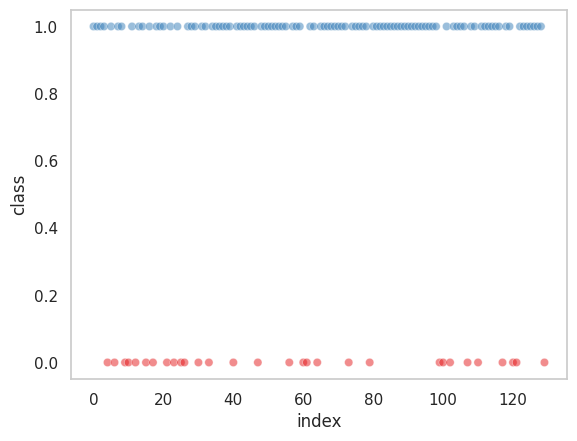

In [ ]:
fig_df = pd.DataFrame(pred).reset_index()
fig_df.rename({0 : 'class'}, axis = 1, inplace = True)

sns.scatterplot(x = 'index', y = 'class', hue = 'class', data = fig_df, legend = False, palette = 'Set1', alpha = 0.5)

<Axes: xlabel='index', ylabel='class'>

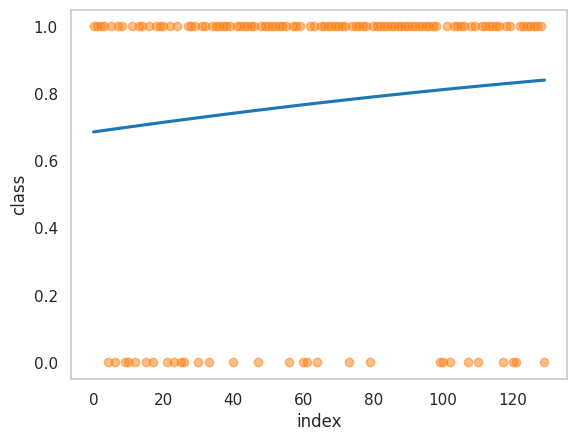

In [ ]:
sns.regplot(x = 'index', y = 'class', data = fig_df, logistic = True, ci = None,
            scatter_kws = {'color' : 'tab:orange', 'alpha' : 0.5}, line_kws = {'color' : 'tab:blue'})
# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/lr-plot.png", bbox_inches = 'tight')

Text(0.5, 1.0, 'Decision boundary from first two features')

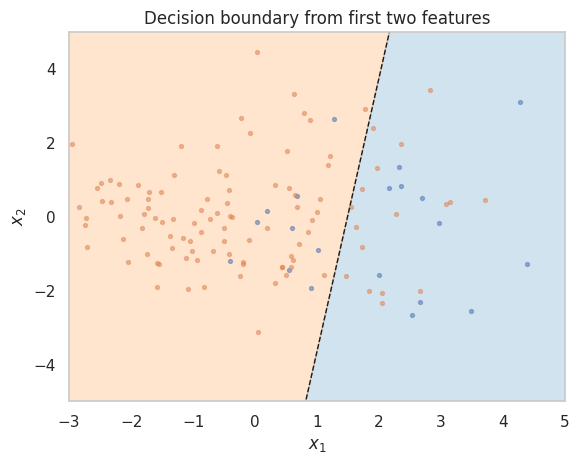

In [ ]:
# from https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/

# Retrieve the model parameters.
b = lr.best_estimator_.intercept_[0]
w1, w2 = lr.best_estimator_.coef_[0][:2].T

# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = -3, 5
ymin, ymax = -5, 5
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

fig_df = pd.DataFrame(X_test).iloc[:, :2] # get first 2 features

plt.scatter(*np.array(fig_df)[y_test==0].T, s=8, alpha=0.5)
plt.scatter(*np.array(fig_df)[y_test==1].T, s=8, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')
plt.title('Decision boundary from first two features')

# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/lr-decision-boundary.png", bbox_inches = 'tight')

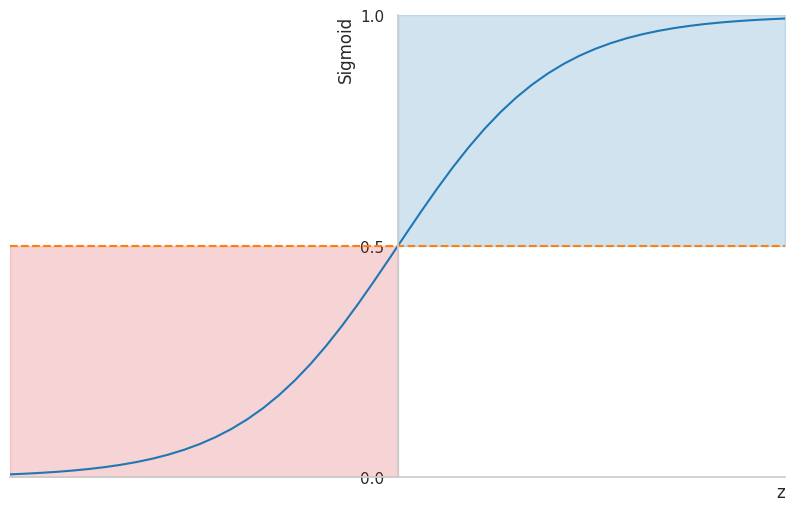

In [ ]:
# sigmoid function

fig, ax = plt.subplots(figsize = (10,6))

x = np.linspace(-5, 5)
y = 1/(1 + np.exp(-x))

sns.lineplot(x=x, y=y, ax = ax, color = 'tab:blue')
ax.axhline(y = 0.5, linestyle = 'dashed', color = 'tab:orange')

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.set_xlim((-5,5))
ax.set_ylim((0,1))
ax.set_ylabel('Sigmoid', loc = 'top')
ax.set_xlabel('z', loc = 'right')
ax.set_xticks([])
ax.set_yticks([0, 0.5, 1])

ax.fill_between(np.array([-5,0]), 0.5, 0, color='tab:red', alpha=0.2)
ax.fill_between(np.array([0,5]), 1, 0.5, color='tab:blue', alpha=0.2)

# ax.title.set_text('LR Sigmoid Function')
# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/lr-sigmoid.png", bbox_inches = 'tight')

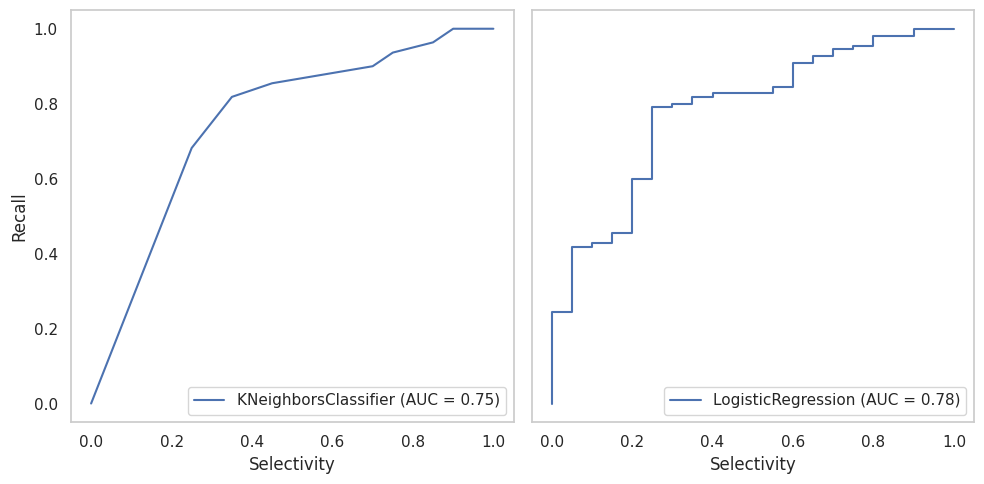

In [ ]:
fig, axs = plt.subplots(1, 2, sharey = True, figsize = (10,5))

RocCurveDisplay.from_estimator(knn, X_test, y_test, ax = axs[0])
RocCurveDisplay.from_estimator(lr, X_test, y_test, ax = axs[1])

axs[0].set_ylabel('Recall')
axs[0].set_xlabel('Selectivity')

axs[1].set_ylabel('')
axs[1].set_xlabel('Selectivity')

plt.tight_layout()
# plt.savefig("/content/drive/MyDrive/UNI/Computer Science/COMP2261 Artificial Intelligence/Machine Learning Coursework/roc-curves.png", bbox_inches = 'tight')